# Kaggle Digit Recognizer
[Digit Recognizer - Learn computer vision fundamentals with the famous MNIST data](https://www.kaggle.com/c/digit-recognizer)



## Pre-requisite

For PCA, the dataset needs to be centered around the origin. To do it manually by yourself with numpy (Scikit Learn PCA looks after centering the data, hence not required).

```
X_centered = X - X.mean(axis=0)
```

# Setup

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import scipy as sp
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)
np.set_printoptions(
    suppress=True #, formatter={'float_kind':'{:0.5f}'.format}
)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
%%html
<!-- To left align the HTML components in Markdown -->
<style>
table {float:left}
</style>

In [7]:
def plot_digit(image):
    reshaped = image.reshape(28, 28)
    plt.imshow(reshaped, cmap="binary")
    plt.axis("off")

In [8]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

# Constants

In [9]:
# Total percentage of the information in the data to preserve after reducing the dimensions
COVERAGE = 0.99

# Number of classes / neighbours to classify
NUM_CLASSES=10

## Loading MNIST data
Download from Kaggle.
* https://www.kaggle.com/c/digit-recognizer/data?select=train.csv
* https://www.kaggle.com/c/digit-recognizer/data?select=test.csv

In [13]:
X_train = pd.read_csv(
    "data/train.csv.zip",
    compression = "zip",
    sep = ",",
    usecols = lambda column : column not in ["label"],
    dtype = np.int16
).to_numpy()
X_train[0].size
X_train.shape

(42000, 784)

In [12]:
y_train = pd.read_csv(
    "data/train.csv.zip",
    compression = "zip",
    sep = ",",
    usecols = lambda column : column in ["label"],
    dtype = np.uint8
).to_numpy()
y_train.size

42000

In [14]:
y_train = [item for sublist in y_train for item in sublist]

In [15]:
y_train[:5]

[1, 0, 1, 4, 0]

In [37]:
X_test = pd.read_csv(
    "data/test.csv.zip",
    compression = "zip",
    sep = ",",
    dtype = np.int16
).to_numpy()
X_test.size / 784

28000.0

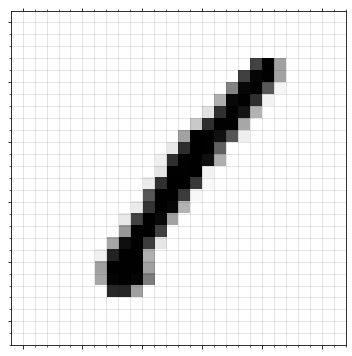

In [17]:
%matplotlib inline

fig = plt.figure(figsize=(6,6))
plt.matshow(X_train[0].reshape(28, 28), fignum=fig.number, cmap=plt.cm.binary)
# Gridlines based on minor ticks
ax = plt.gca();

# Minor ticks
ax.set_xticks(np.arange(0.5, 28, 1), minor=True)
ax.set_yticks(np.arange(0.5, 28, 1), minor=True)

# Major ticks
ax.set_xticks(np.arange(0.5, 28, 5))
ax.set_yticks(np.arange(0.5, 28, 5))

ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

ax.grid(which='minor', color='k', alpha=0.1, linestyle='-', linewidth=1)
ax.grid(which='major', color='k', alpha=0.1, linestyle='-', linewidth=1)

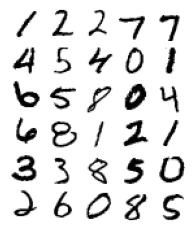

In [18]:
%matplotlib inline
plot_digits(X_train[::1400])
plt.show()

In [19]:
%matplotlib inline
plot_digits(X_test[::700])
plt.show()

NameError: name 'X_test' is not defined

# Principal Components

## Eigenvalues
Hence Principal Comonents can be identified from the eigenvalues. Contribution at each basis to the total information is <span style="color:red"><b>its variance</b></span>, which is represented by eigenvalues.

In [20]:
X_centered = X_train - X_train.mean(axis=0)

covariance_matrix = X_centered.T.dot(X_centered) 
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

### Plot eigenvalue cumulative

Visualize how much percentage of the total information in the data can be represented with how many principal components.

In [21]:
def plot_coverage(cumulatives, xlabel, ylabel):
    dimensions = range(0, len(cumulatives))

    # --------------------------------------------------------------------------------
    # Axes
    # [Axis limits]
    # With plt.axes() you are creating a new axes again. 
    # Use ax.set_xlim(a,b) and ax.set_ylim(a,b)
    # --------------------------------------------------------------------------------
    #plt.axis((0,max(dimensions),0,1.01))
    # --------------------------------------------------------------------------------
    ax = plt.gca()
    ax.set_xlim(0, max(dimensions))
    ax.set_ylim(0, 1.01)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # --------------------------------------------------------------------------------
    # Grid
    # --------------------------------------------------------------------------------
    import math
    import matplotlib.ticker as ticker

    plt.grid(
        color='b',
        linestyle='--',
        linewidth=0.5,
        which='both'     # Both major and minor grids
    )

    # --------------------------------------------------------------------------------
    # Minor grid to highlight the range for the COVERAGE
    # --------------------------------------------------------------------------------
    k = np.argmax(cumulatives >= COVERAGE)
    print("k-th principal compoent for {0} coverage is {1}".format(str(COVERAGE), k))
    
    minors = range(0, math.ceil(k/100)*100, 10)[1:-1]
    ax.xaxis.set_minor_locator(ticker.FixedLocator(minors))
    ax.grid(
        which='minor', # Set the minor grid attributes
        alpha=0.5,     # Transparency
        lw=1, 
        color='r'
    )

    # --------------------------------------------------------------------------------
    # Cut-off COVERAGE line 
    # --------------------------------------------------------------------------------
    plt.plot([0.0, max(dimensions)], [COVERAGE, COVERAGE], "r:", lw=2, label=str(COVERAGE))
    
    # --------------------------------------------------------------------------------
    # Information coverage along Principal Components 
    # --------------------------------------------------------------------------------
    plt.plot(dimensions, cumulatives)

    plt.legend(
        loc='upper right',          # Legend location
        bbox_to_anchor=(0.98, 0.9), # Adjust the legend location
        prop={'size': 15}           # Font size
    )
    plt.show

k-th principal compoent for 0.99 coverage is 330


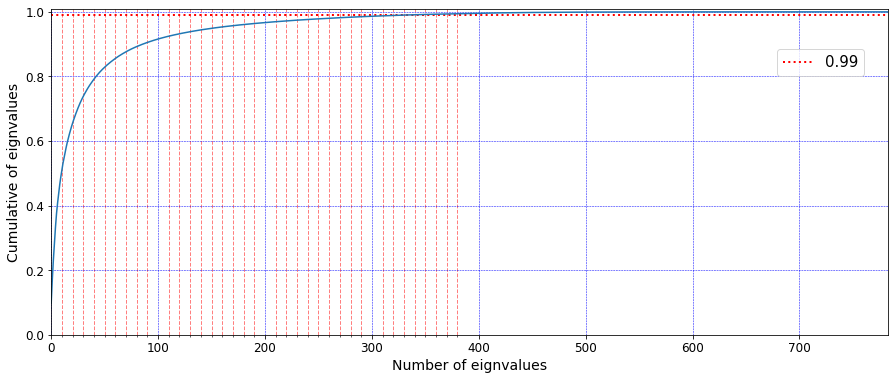

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plot_coverage(
    (eigenvalues / eigenvalues.sum()).cumsum(), 
    "Number of eignvalues", 
    "Cumulative of eignvalues"
)

The COVERAGE rate (e.g 0.95 = 95%) of the information in the data is represented with 154 PCs out of 784.

In [23]:
del eigenvalues

<hr/>

# PCA

Demonstrate the Scikit Learn PCA which identifies the top <b>k</b> principal components and ignore the rest of the components, by which the dimentionality can be reduced from n to k.

<img align="left" src="./images/pca/pca.idea.png" width="400">
<br/>

## Choosing k

Find <b>k</b> which covers 99% (or 95%) of the variance of the data. <br/>. The coverage is specified in the COVERGE variable.

<cite><b> Andrew Ng</b></cite>
<pre>
<img align="left" src="./images/pca/andrew_ng_choosing_k.png" width="750">
</pre>

In [24]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)

PCA()

## Identify k for the coverage

Idenify the number of component (k+1) that cover the COVERAGE % of the information that the data has. Scikit Learn PCA.explained_variance_ratio_ tells the ratio of information each PC contributes to the data.

k-th principal compoent for 0.99 coverage is 330
Contributions of the top 5 principal components : [0.09749 0.0716  0.06146 0.05379 0.04894]
Cumulation of the top 5 principal components: [0.09749 0.16909 0.23055 0.28434 0.33329]


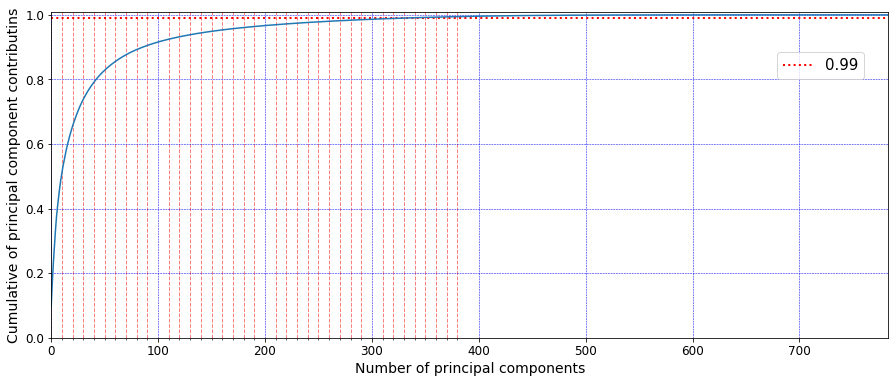

In [25]:
contribution_cumulatives = pca.explained_variance_ratio_.cumsum()

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plot_coverage(
    pca.explained_variance_ratio_.cumsum(), 
    "Number of principal components", 
    "Cumulative of principal component contributins"
)

print("Contributions of the top 5 principal components : {}".
      format(np.round(pca.explained_variance_ratio_[:5], decimals=5))
)
print("Cumulation of the top 5 principal components: {}".
      format(np.round(contribution_cumulatives[:5], decimals=5))
)

## Effect of the dimensionality reduction

Compare the original image and the one restored from the dimension reduced data.

In [26]:
pca = PCA(
    n_components=np.argmax(pca.explained_variance_ratio_.cumsum() >= COVERAGE) #, 
#    svd_solver="randomized", 
#    random_state=4
)
X_train_reduced = pca.fit_transform(X_train)
X_train_recovered = pca.inverse_transform(X_train_reduced)

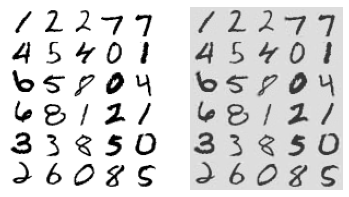

In [27]:
%matplotlib inline

plt.subplot(121)
plot_digits(X_train[::1400])

plt.subplot(122)
plot_digits(X_train_recovered[::1400])
#plt.tight_layout()

In [28]:
#del X_train_reduced, X_train_recovered
#del pca, _pca

In [29]:
%%html
<style>
row {float:left}
</style>

## Visualize how two principal components can classify digits

For instance, digit 7 is represented by the Orange color. In the PC2 / PC4 space, '7' has a clear cluster.

| PC | PC | Description         
| :- | :- | :-
|PC1 | PC1 |Classifies digit 0  
|PC1 | PC2 |Classifies digit 1, 2, 7  
|PC2 | PC3 |Classifies digit 3
|PC2 | PC4 |Classifies digit 2, 7
|PC4 | PC4 |Classifies digit 6


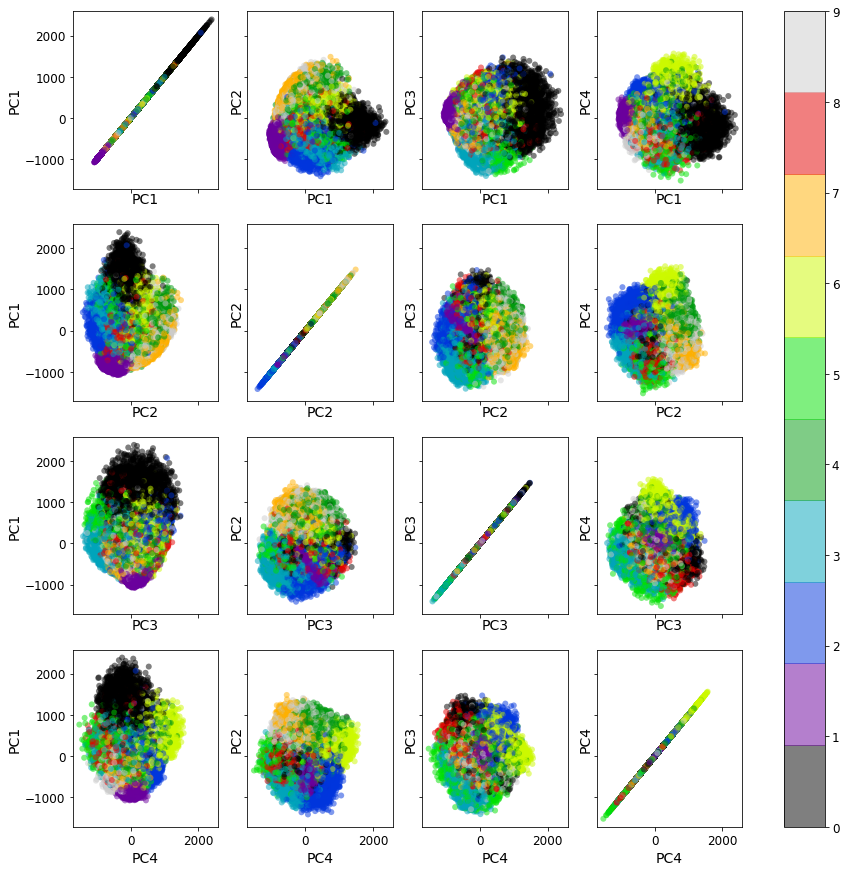

In [30]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

nrows = 4
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(15, 15))

def plot_grid(projected, axes, x, y):
    path = axes[x, y].scatter(
        projected[:, x],
        projected[:, y], 
        c=y_train, 
        edgecolor='none', 
        alpha=0.5,
        cmap=plt.cm.get_cmap('nipy_spectral', 10)
    )
    axes[x, y].set_xlabel('PC{}'.format(x+1))
    axes[x, y].set_ylabel('PC{}'.format(y+1))
    return path

for i in range(0, nrows * ncols):
    path = plot_grid(X_train_reduced, axes, i % ncols, i // nrows)

cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat], orientation="vertical")
plt.colorbar(path, cax=cax, **kw)
   
#plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


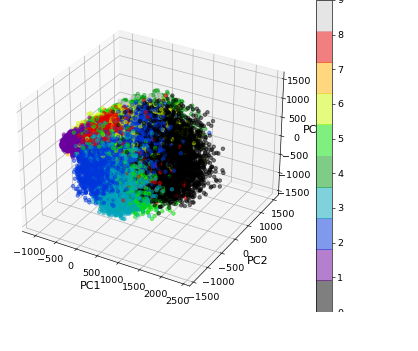

In [42]:
from mpl_toolkits.mplot3d import Axes3D

# --------------------------------------------------------------------------------
# To switch matplotlib backend
# https://stackoverflow.com/questions/43545050
# --------------------------------------------------------------------------------
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_grid_3D(projected, fig):
    ax = Axes3D(fig)
    path = ax.scatter(
        projected[:, 0], 
        projected[:, 1],
        projected[:, 2],
        c=y_train, 
        alpha=0.5,
        cmap=plt.cm.get_cmap('nipy_spectral', 10)
    )
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    fig.colorbar(path)
    
fig = plt.figure(figsize=(8, 6))
plot_grid_3D(X_train_reduced, fig)
plt.show()

## KNN on dimension reduced data

Demonstrate the KNN (K Nearest Neighbour) to predict the hand written digits on the dimension reduced data. 
The time take on a Ubuntu 18.04 LTS PC with Intel Core i7 4th Gen 4770 with 8G memory:
<pre>
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  5.5min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  6.8min finished
</pre>

For comparision, the time taken for not dimension reduced data using AWS ml.c4.4xlarge instance on AWS:
 
<pre>
Using backend LokyBackend with 16 concurrent workers.
Done   3 out of  10 | elapsed: 62.4min remaining: 145.6min
Done   7 out of  10 | elapsed: 64.3min remaining: 27.6min
Done  10 out of  10 | elapsed: 64.4min finished
</pre>

In [32]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(
    n_neighbors=NUM_CLASSES, 
    weights='distance',
    n_jobs=-1           # Use all processors
)

params_knn = knn.get_params()
print("KNN parameters = {}".format(params_knn))

KNN parameters = {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}


In [33]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {
        'weights': ["uniform", "distance"], 
        'n_neighbors': [NUM_CLASSES]
    }
]
grid_search = GridSearchCV(knn, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train_reduced, y_train)
knn = grid_search.best_estimator_

print("GridSearchCV best parameters for KNN is {}".format(grid_search.best_params_))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  7.8min remaining: 18.3min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  7.9min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.0min finished


GridSearchCV best parameters for KNN is {'n_neighbors': 10, 'weights': 'distance'}


In [34]:
y_train_pred_knn = knn.predict(X_train_reduced)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred_knn)

array([[4132,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 4684,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 4177,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 4351,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 4072,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 3795,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 4137,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 4401,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 4063,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 4188]])

In [35]:
from sklearn.metrics import accuracy_score
accuracy_knn = accuracy_score(y_train, y_train_pred_knn)

from sklearn.metrics import precision_recall_fscore_support as score
precision_knn, recall_knn, fscore_knn, support_knn = score(y_train, y_train_pred_knn)

import pandas as pd
data_knn = [
#    np.append(["Accracy"], accuracy_knn),
    np.append(["Precision"], precision_knn),
    np.append(["Recall"], recall_knn),
    np.append(["F1"], fscore_knn),
    np.append(["Support"], support_knn)
]
pd.DataFrame(data_knn)

,0,1,2,3,4,5,6,7,8,9,10
0,Precision,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,Recall,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,F1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,Support,4132,4684,4177,4351,4072,3795,4137,4401,4063,4188


# Prediction

In [38]:
X_test_reduced = pca.transform(X_test)
y_test_pred_knn = knn.predict(X_test_reduced).astype(np.int8)

In [39]:
y_test_pred_knn[:5]

array([2, 0, 9, 9, 3], dtype=int8)

In [40]:
np.savetxt("results/kaggle_digit_recognizer_pca_knn.csv", y_test_pred_knn, delimiter=",", fmt='%d')